# Validation/Verification & Performance comparison for LOGIC gates with multiple hidden layers and multiple neurons

For Google Colab or Kaggle install crysx_nn

In [ ]:
! pip install --upgrade https://github.com/manassharma07/crysx_nn/tarball/main

## Import stuff

In [1]:
import numpy as np
print('numpy',np.__version__)

import matplotlib.pyplot as plt


# Import loss functions
from crysx_nn.loss import MSE_loss, MSE_loss_grad
from crysx_nn.loss import BCE_loss, BCE_loss_grad
# Import activation functions
from crysx_nn.activation import Sigmoid, Sigmoid_grad
from crysx_nn.activation import ReLU, ReLU_grad
from crysx_nn.activation import Softmax, Softmax_grad
from crysx_nn.activation import Tanh_offset, Tanh_offset
# Import neural network functions
from crysx_nn.network import back_propagation, back_propagation_fast
from crysx_nn.network import nn_optimize, nn_optimize_fast
from crysx_nn.network import forward_feed
from crysx_nn.network import visualize


from tqdm.notebook import tqdm


# import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
print('tf',tf.__version__)

import torch, torchvision
print('torch',torch.__version__)
rng = np.random.default_rng()
import time
from timeit import default_timer as timer

numpy 1.19.2


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\crysx_nn\network.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


tf 2.2.3
torch 1.10.1


## Ensure that evertyhing is only using CPU

In [2]:
torch.cuda.is_available()

False

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
print(tf.test.is_built_with_cuda())

True


## Check if NumPy is linked with MKL or not

In [6]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = [

## Start with the common stuff

In [7]:
nInputs = 2 # No. of features
nOutputs = 1
neurons_per_layer = [500,500,1] # Hidden layers and output layer
activation_func_names = ['Sigmoid','Sigmoid','Sigmoid']
nLayers = len(neurons_per_layer)
eeta = 0.5
nEpochs=10**4
batchSize = 4

#### Activation function dictionary for all the frameworks

In [8]:


act_func_dict_PyTorch = {'Sigmoid':torch.nn.Sigmoid(),'ReLU':torch.nn.ReLU(),'ELU':torch.nn.ELU(), 'Hardshrink' : torch.nn.Hardshrink(),'Hardsigmoid':torch.nn.Hardsigmoid(),\
                 'Hardtanh':torch.nn.Hardtanh(),'Hardswish':torch.nn.Hardswish(),'LeakyReLU':torch.nn.LeakyReLU(),'LogSigmoid':torch.nn.LogSigmoid(),\
                 'Tanh':torch.nn.Tanh(),'Softmax':torch.nn.Softmax(dim=1),'Softmin':torch.nn.Softmin(dim=1),'LogSoftmax':torch.nn.LogSoftmax()}
act_func_dict_tensorflow = {'Sigmoid':'sigmoid','Softmax':'softmax','ReLU':'relu','LeakyReLU':'leakyrelu'}



## Visualize 

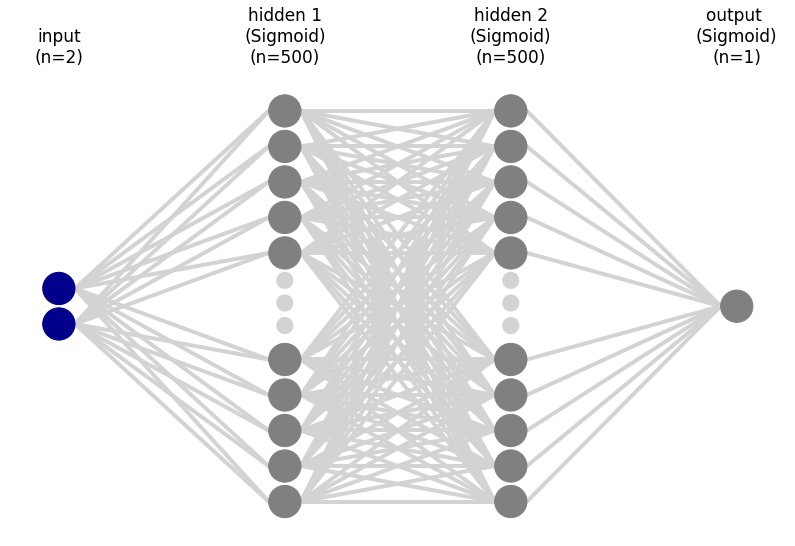

In [9]:
visualize(nInputs, neurons_per_layer, activation_func_names)

## Set inputs

In [10]:
inputs = np.array([[0.,0.,1.,1.],[0.,1.,0.,1.]]).T.astype('float32')
print(inputs)
print(inputs.dtype)


[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
float32


In [11]:
# AND function
outputAND = np.array([0.,0.,0.,1.])
outputAND = np.asarray([outputAND]).T
# OR function
outputOR = np.array([0.,1.,1.,1.])
outputOR = np.asarray([outputOR]).T
# NAND function
outputNAND = np.array([1.,1.,1.,0.])
outputNAND = np.asarray([outputNAND]).T
# XOR function
outputXOR = np.array([0.,1.,1.,0.])
outputXOR = np.asarray([outputXOR]).T

## Set outputs

In [12]:
# outputs = outputAND
# outputs = outputOR
# outputs = outputNAND
outputs = outputXOR
outputs = outputs.astype('float32')
print(outputs)
print(outputs.dtype)

[[0.]
 [1.]
 [1.]
 [0.]]
float32


# Keras implementation

In the following we have to be careful and change the network nodes, and layers manually. 

TODO: Make the neural network be generated in a loop automatically using the parameters already defined.

In [13]:
# # define the keras model
# model = Sequential()
# model.add(Dense(100, input_dim=2, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(1, activation='sigmoid', use_bias=True))

# model.summary()

## Make the neural network programatically

In [14]:
# define the keras model
model = Sequential()
# First Hidden layer
model.add(Dense(neurons_per_layer[0], input_dim=nInputs, activation=act_func_dict_tensorflow[activation_func_names[0]], use_bias=True))

if nLayers>1:
    # Hidden layers
    for i in range(nLayers-2):
        model.add(Dense(neurons_per_layer[i], activation=act_func_dict_tensorflow[activation_func_names[i]], use_bias=True))
    # Output layer
    model.add(Dense(neurons_per_layer[nLayers-1], activation=act_func_dict_tensorflow[activation_func_names[nLayers-1]], use_bias=True))
    
model.summary()
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              3000      
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 1,005,001
Trainable params: 1,005,001
Non-trainable params: 0
_________________________________________________________________


## Check the initial weights and biases for each layer

Note how the weights matrix is not 4x2 but rather 2x4

In [15]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[-0.05481618 -0.07514875 -0.05178761 ... -0.00265513  0.03108551
  -0.03112719]
 [-0.0312356  -0.04124607 -0.02765363 ...  0.01201439  0.04898621
   0.00077369]]

 Biases for layer  1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

## Save the weights generated by tf.keras and use them for our implementation as well

In [16]:
weightsOriginal = []
biasesOriginal = []


for i in range(nLayers):
    weightsOriginal.append(model.layers[i].get_weights()[0].T)
    biasesOriginal.append(model.layers[i].get_weights()[1].T)

print('Weights matrices: ',weightsOriginal)
print('Biases: ',biasesOriginal)

Weights matrices:  [array([[-0.05481618, -0.0312356 ],
       [-0.07514875, -0.04124607],
       [-0.05178761, -0.02765363],
       ...,
       [-0.00265513,  0.01201439],
       [ 0.03108551,  0.04898621],
       [-0.03112719,  0.00077369]], dtype=float32), array([[-0.02278712,  0.04513193, -0.02632104, ..., -0.01146608,
        -0.0530388 , -0.01176712],
       [-0.00755975, -0.04793255,  0.05413422, ...,  0.05298672,
        -0.04125094,  0.04617357],
       [ 0.01305118, -0.01379363, -0.00113949, ...,  0.00807054,
         0.0031071 ,  0.0244013 ],
       ...,
       [-0.04045843, -0.00555543,  0.04794147, ...,  0.04782118,
         0.01415828, -0.0424128 ],
       [ 0.03478888, -0.03565441, -0.01979981, ..., -0.03605823,
         0.02533802,  0.00888978],
       [-0.02621366,  0.02586373,  0.03254594, ...,  0.01878073,
        -0.04992818, -0.02299018]], dtype=float32), array([[ 5.90534210e-02,  1.99544430e-02,  4.27139550e-03,
        -1.13012195e-02,  2.23244727e-02,  2.15218589

## Compile model

In [17]:
# compile the keras model

# In the following manner we can't set the learning rate of the optimizer
# model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

# So use the following instead
model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['mse'])



## Forward feed

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [58]:
model.evaluate(inputs, outputs, batch_size=batchSize)

1/1 [==============================] - 0s 0s/step - loss: 0.2535 - mse: 0.2535


[0.2534654438495636, 0.2534654438495636]

## Does tf.model.evaluate change the weights and biases?

In [59]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.04660975  0.00104529 -0.01703642 ... -0.01405991 -0.02388688
   0.06647673]
 [-0.03478231  0.06030388 -0.04122769 ...  0.04487106  0.02048098
   0.0581727 ]]

 Biases for layer  1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

From the above, we can be sure that it does not change the weights and biases

## Fit 1 epoch  (forward feed, backpropagation, updating the weights, biases)

Let us just try to see and compare the error after just 1 epoch. 

We should expect the model to perform forward feed, calculate loss/error,
perform backpropagation,
and adjust the weights and biases based on the learning rate.

Note: Batch size=32 indicates that we are using all the training data(examples) in batches.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [15]:
# fit the keras model on the dataset
model.fit(inputs, outputs, epochs=1, batch_size=batchSize)

1/1 [==============================] - 0s 990us/step - loss: 0.3305 - mse: 0.3305


## Now the weights and biases must have been updated

In [16]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.11635079 -0.69993484  0.2585289  -0.24266696  0.42531872 -0.11734872
  -0.299859   -0.15040949  0.34065038 -0.28196827]
 [-0.32157964  0.1653209   0.21613823 -0.56332827 -0.01603435 -0.6756115
  -0.66626745  0.5548515  -0.00379604 -0.28168988]]

 Biases for layer  1
[-0.00748931  0.00433109  0.00662372 -0.00488656 -0.00779686 -0.00108488
 -0.0037135  -0.00706877 -0.00617347 -0.00331984]

 Weights for layer  2
[[ 0.60486984]
 [-0.39378285]
 [-0.59994036]
 [ 0.42704973]
 [ 0.6415346 ]
 [ 0.07881472]
 [ 0.3327246 ]
 [ 0.57281923]
 [ 0.49921402]
 [ 0.27066505]]

 Biases for layer  2
[-0.04775559]


## Now let us do a forward feed again and calculate the loss/error

In [17]:
out = model.evaluate(inputs, outputs, batch_size=batchSize)
print(out)

1/1 [==============================] - 0s 990us/step - loss: 0.3147 - mse: 0.3147
[0.31468090415000916, 0.31468090415000916]


### The above result, compares well with the result from my own implementation (when biases are updated independently)

## Now let us let the model train for 10^4 epochs



In [60]:
%%time
# fit the keras model on the dataset
# history = model.fit(tf.convert_to_tensor(inputs, dtype=tf.float32), tf.convert_to_tensor(outputs, dtype=tf.float32), epochs=nEpochs, batch_size=nSamples, verbose=0)
history = model.fit(inputs, outputs, epochs=nEpochs, batch_size=batchSize, verbose=0)

Wall time: 15.5 s


Turns out that this was quite slow. At first, I thought that the problem was that it was printing at each epoch. So I set the verbose=0 (silent). But still, it was incredibly slow compared to my implementation as well as PyTorch, even though we used own for loop in both the cases.

In [61]:
history.history

{'loss': [0.2534654438495636,
  0.48312515020370483,
  0.3640035390853882,
  0.4999926686286926,
  0.4999926686286926,
  0.4999926686286926,
  0.4999926686286926,
  0.4999926686286926,
  0.49999263882637024,
  0.49999260902404785,
  0.49999260902404785,
  0.49999260902404785,
  0.49999260902404785,
  0.49999260902404785,
  0.49999260902404785,
  0.49999260902404785,
  0.49999257922172546,
  0.4999925494194031,
  0.4999925494194031,
  0.4999925494194031,
  0.4999925494194031,
  0.4999925494194031,
  0.4999925494194031,
  0.4999925196170807,
  0.4999924898147583,
  0.4999924898147583,
  0.4999924898147583,
  0.4999924898147583,
  0.4999924898147583,
  0.4999924898147583,
  0.4999924600124359,
  0.4999924302101135,
  0.4999924302101135,
  0.4999924302101135,
  0.4999924302101135,
  0.4999924302101135,
  0.4999924302101135,
  0.49999240040779114,
  0.49999237060546875,
  0.49999237060546875,
  0.49999237060546875,
  0.49999237060546875,
  0.49999237060546875,
  0.49999237060546875,
  0.499

## Now also let us have a look at the predictions for the sake of the tutorial

In [62]:
# make probability predictions with the model
predictions = model.predict(inputs)
print(predictions)

[[0.49962994]
 [0.4999237 ]
 [0.5000853 ]
 [0.5003636 ]]


## We have seen how to initialize custom weights/biases, perform forward feed, train/optimize the model, and finally how to check the updated parameters.


## Let us now see how we can see the input/output at each layer for debugging purposes.

In [63]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_3_input:0", shape=(None, 2), dtype=float32)

 Outputs for layer  1
Tensor("dense_3/Identity:0", shape=(None, 1000), dtype=float32)

 Inputs for layer  2
Tensor("dense_3/Identity:0", shape=(None, 1000), dtype=float32)

 Outputs for layer  2
Tensor("dense_4/Identity:0", shape=(None, 1000), dtype=float32)

 Inputs for layer  3
Tensor("dense_4/Identity:0", shape=(None, 1000), dtype=float32)

 Outputs for layer  3
Tensor("dense_5/Identity:0", shape=(None, 1), dtype=float32)


In [64]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_3_input:0", shape=(None, 2), dtype=float32)

 Outputs for layer  1
Tensor("dense_3/Identity:0", shape=(None, 1000), dtype=float32)

 Inputs for layer  2
Tensor("dense_3/Identity:0", shape=(None, 1000), dtype=float32)

 Outputs for layer  2
Tensor("dense_4/Identity:0", shape=(None, 1000), dtype=float32)

 Inputs for layer  3
Tensor("dense_4/Identity:0", shape=(None, 1000), dtype=float32)

 Outputs for layer  3
Tensor("dense_5/Identity:0", shape=(None, 1), dtype=float32)


## We can't really see any numbers in the above output
## So we need to do something more

In [65]:
for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).input)
    layerInput = func([inputs])  # input_data is a numpy array
    print(layerInput)
    print('\n Outputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).output)
    layerOutput = func([inputs])  # input_data is a numpy array
    print(layerOutput)





 Inputs for layer  1
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]

 Outputs for layer  1
[[0.5017259  0.5003342  0.5010516  ... 0.49993643 0.49998185 0.5007477 ]
 [0.49394816 0.51578146 0.49124247 ... 0.5114521  0.50517356 0.51588064]
 [0.5144635  0.5006485  0.49748072 ... 0.4959734  0.49347043 0.51736933]
 [0.506689   0.5160954  0.48767316 ... 0.5074904  0.498662   0.5324688 ]]

 Inputs for layer  2
[[0.5017259  0.5003342  0.5010516  ... 0.49993643 0.49998185 0.5007477 ]
 [0.49394816 0.51578146 0.49124247 ... 0.5114521  0.50517356 0.51588064]
 [0.5144635  0.5006485  0.49748072 ... 0.4959734  0.49347043 0.51736933]
 [0.506689   0.5160954  0.48767316 ... 0.5074904  0.498662   0.5324688 ]]

 Outputs for layer  2
[[0.17010745 0.16760144 0.18075517 ... 0.18036884 0.18491036 0.19697583]
 [0.1676045  0.16590533 0.18279171 ... 0.18007344 0.18252787 0.19761065]
 [0.17361066 0.16632026 0.18136725 ... 0.1825256  0.18284446 0.19837645]
 [0.17106709 0.16463369 0.18340781 ... 0.18222556 0.18048209 0.19901

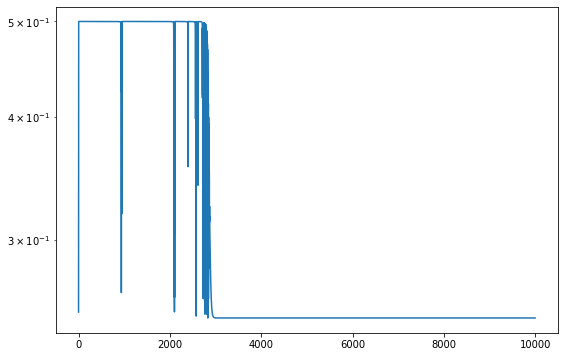

In [66]:
# Plot the error vs epochs
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

# My implementation

## Forwad feed once

In [67]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# Error
print('Error:\n', MSE_loss(a[nLayers],outputs)/batchSize)

Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.4913053 , 0.5150714 , 0.48969454, ..., 0.51121587, 0.50512004,
        0.51453906],
       [0.5116503 , 0.5002613 , 0.495741  , ..., 0.49648508, 0.49402857,
        0.51661307],
       [0.5029568 , 0.51533246, 0.48543808, ..., 0.5077022 , 0.49914855,
        0.5311221 ]], dtype=float32), array([[0.4984254 , 0.46076646, 0.56886876, ..., 0.5698056 , 0.5836653 ,
        0.6989868 ],
       [0.49524614, 0.458468  , 0.573172  , ..., 0.57023513, 0.5806717 ,
        0.7005067 ],
       [0.5047503 , 0.45885092, 0.5706366 , ..., 0.57401645, 0.5808821 ,
        0.70133555],
       [0.5015705 , 0.45655218, 0.57493234, ..., 0.5744415 , 0.57788163,
        0.7028471 ]], dtype=float32), array([[0.4409284 ],
       [0.44109148],
       [0.4411658 ],
       [0.441327

## Backpropagation

In [68]:
# Get the derivative of the output cost function wrt to the output vector of the output layer
# The input arguments should always be an array
dc_daL = MSE_loss_grad(a[nLayers], outputs)/batchSize
print('Gradient of the error function wrt to the predicted output of the output layer\n',dc_daL)

# Perform Back Propagation and get the derivatives wrt the weights and biases
derWeights, derBiases, weights, biases = back_propagation(z, a, activation_func_names, nLayers, batchSize, weightsOriginal, biasesOriginal, eeta, dc_daL)
print('Gradient of Cost (error function) wrt weights:\n',derWeights)
print('Gradient of Cost (error function) wrt biases:\n',derBiases)

Gradient of the error function wrt to the predicted output of the output layer
 [[ 0.2204642 ]
 [-0.27945426]
 [-0.2794171 ]
 [ 0.2206636 ]]
Gradient of Cost (error function) wrt weights:
 [array([[ 4.5570850e-05,  4.6199086e-05],
       [-7.7997593e-06, -8.3993928e-06],
       [-4.0849423e-05, -4.0624800e-05],
       ...,
       [ 1.1547563e-05,  1.1951601e-05],
       [-2.1081414e-06, -3.4952245e-06],
       [ 3.5943216e-05,  3.6386569e-05]], dtype=float32), array([[-1.7024155e-04, -1.7234046e-04, -1.6727345e-04, ...,
        -1.7104673e-04, -1.6959870e-04, -1.7503850e-04],
       [-1.3826622e-04, -1.3997388e-04, -1.3584868e-04, ...,
        -1.3892044e-04, -1.3774142e-04, -1.4217157e-04],
       [-2.9263301e-05, -2.9622832e-05, -2.8748265e-05, ...,
        -2.9399002e-05, -2.9148825e-05, -3.0091374e-05],
       ...,
       [-8.9015390e-05, -9.0135072e-05, -8.7462060e-05, ...,
        -8.9455090e-05, -8.8692250e-05, -9.1545226e-05],
       [-8.2710088e-05, -8.3723469e-05, -8.1278806e

## Gradient descent (update the weights and biases)

In [69]:
newWeights = [weightsOriginal[i] - eeta*derWeights[i] for i in range(nLayers)]
print('New Weights: ', newWeights)

newBiases = [biasesOriginal[i] - eeta*derBiases[i] for i in range(nLayers)]
# newBiases = biasesOriginal
print('New Biases: ', newBiases)

New Weights:  [array([[ 0.04658697, -0.03480541],
       [ 0.00104919,  0.06030808],
       [-0.017016  , -0.04120738],
       ...,
       [-0.01406568,  0.04486509],
       [-0.02388582,  0.02048272],
       [ 0.06645876,  0.05815451]], dtype=float32), array([[ 0.01260279, -0.02058725, -0.03540996, ..., -0.02231975,
         0.03164893, -0.01792644],
       [-0.01483923, -0.00039165, -0.01388053, ...,  0.00513362,
         0.04836282,  0.01928068],
       [-0.03844792, -0.0271136 ,  0.03272383, ...,  0.01547186,
        -0.00142574,  0.03545398],
       ...,
       [ 0.03281859,  0.0436378 , -0.00486387, ..., -0.01918886,
        -0.02312086, -0.02605676],
       [-0.02871564, -0.01399547,  0.02202874, ...,  0.03133919,
         0.00774767, -0.03097128],
       [ 0.02413133,  0.05039556,  0.04735867, ...,  0.04138732,
        -0.05272782, -0.04648083]], dtype=float32), array([[ 5.40557839e-02,  4.49094959e-02,  1.65101420e-02,
         3.03802155e-02,  5.33736646e-02,  1.82031319e-02,

## Forward feed again and check the loss/error

In [70]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# New Error
print('New Error:\n', MSE_loss(a[nLayers],outputs)/batchSize)

Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.4913053 , 0.5150714 , 0.48969454, ..., 0.51121587, 0.50512004,
        0.51453906],
       [0.5116503 , 0.5002613 , 0.495741  , ..., 0.49648508, 0.49402857,
        0.51661307],
       [0.5029568 , 0.51533246, 0.48543808, ..., 0.5077022 , 0.49914855,
        0.5311221 ]], dtype=float32), array([[0.4984254 , 0.46076646, 0.56886876, ..., 0.5698056 , 0.5836653 ,
        0.6989868 ],
       [0.49524614, 0.458468  , 0.573172  , ..., 0.57023513, 0.5806717 ,
        0.7005067 ],
       [0.5047503 , 0.45885092, 0.5706366 , ..., 0.57401645, 0.5808821 ,
        0.70133555],
       [0.5015705 , 0.45655218, 0.57493234, ..., 0.5744415 , 0.57788163,
        0.7028471 ]], dtype=float32), array([[0.4409284 ],
       [0.44109148],
       [0.4411658 ],
       [0.441327

## ** With np.einsum (slightly Slower than opt_einsum expression reuse)**

In [18]:
%%time

# Run optimization
optWeights, optBiases, errorPlot = nn_optimize(inputs, outputs, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=MSE_loss, gradErrorFunc=MSE_loss_grad,miniterEpoch=100,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.28651800751686096
Wall time: 57 s


In [72]:
print(errorPlot)

[0.2534655034542084, 0.48312515020370483, 0.3640040159225464, 0.4999926686286926, 0.4999926686286926, 0.4999926686286926, 0.4999926686286926, 0.4999926686286926, 0.49999263882637024, 0.49999260902404785, 0.49999260902404785, 0.49999260902404785, 0.49999260902404785, 0.49999260902404785, 0.49999260902404785, 0.49999260902404785, 0.49999257922172546, 0.4999925494194031, 0.4999925494194031, 0.4999925494194031, 0.4999925494194031, 0.4999925494194031, 0.4999925494194031, 0.4999925196170807, 0.4999924898147583, 0.4999924898147583, 0.4999924898147583, 0.4999924898147583, 0.4999924898147583, 0.4999924898147583, 0.4999924600124359, 0.4999924302101135, 0.4999924302101135, 0.4999924302101135, 0.4999924302101135, 0.4999924302101135, 0.4999924302101135, 0.49999240040779114, 0.49999237060546875, 0.49999237060546875, 0.49999237060546875, 0.49999237060546875, 0.49999237060546875, 0.49999237060546875, 0.49999234080314636, 0.499992311000824, 0.499992311000824, 0.499992311000824, 0.499992311000824, 0.499

In [73]:
print(errorPlot)

[0.2534655034542084, 0.48312515020370483, 0.3640040159225464, 0.4999926686286926, 0.4999926686286926, 0.4999926686286926, 0.4999926686286926, 0.4999926686286926, 0.49999263882637024, 0.49999260902404785, 0.49999260902404785, 0.49999260902404785, 0.49999260902404785, 0.49999260902404785, 0.49999260902404785, 0.49999260902404785, 0.49999257922172546, 0.4999925494194031, 0.4999925494194031, 0.4999925494194031, 0.4999925494194031, 0.4999925494194031, 0.4999925494194031, 0.4999925196170807, 0.4999924898147583, 0.4999924898147583, 0.4999924898147583, 0.4999924898147583, 0.4999924898147583, 0.4999924898147583, 0.4999924600124359, 0.4999924302101135, 0.4999924302101135, 0.4999924302101135, 0.4999924302101135, 0.4999924302101135, 0.4999924302101135, 0.49999240040779114, 0.49999237060546875, 0.49999237060546875, 0.49999237060546875, 0.49999237060546875, 0.49999237060546875, 0.49999237060546875, 0.49999234080314636, 0.499992311000824, 0.499992311000824, 0.499992311000824, 0.499992311000824, 0.499

#### Test the quality of the weights by running a forward feed again

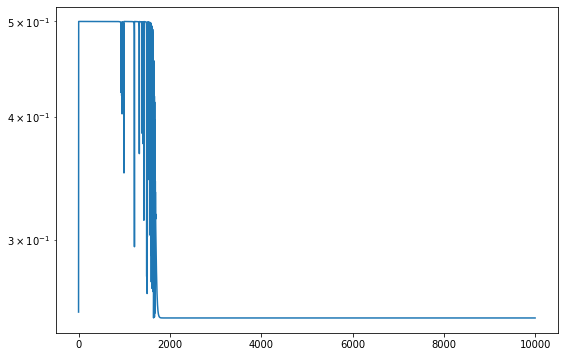

In [74]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [75]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', MSE_loss(a[nLayers],outputs)/batchSize)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[ 0.05118688, -0.03107772],
       [ 0.00117756,  0.0619949 ],
       [-0.01412986, -0.0392774 ],
       ...,
       [-0.01611583,  0.04629422],
       [-0.02647175,  0.02085646],
       [ 0.06630987,  0.06071104]], dtype=float32), array([[ 0.00957292, -0.024045  , -0.03849005, ..., -0.02573681,
         0.02831871, -0.02127075],
       [-0.01778125, -0.00333705, -0.01682978, ...,  0.00218487,
         0.04542258,  0.01636313],
       [-0.04203574, -0.03073844,  0.02920279, ...,  0.0118767 ,
        -0.00498657,  0.03176183],
       ...,
       [ 0.02921854,  0.03991483, -0.00839707, ..., -0.02286146,
        -0.0267444 , -0.02981564],
       [-0.03239606, -0.01769001,  0.0183905 , ...,  0.02766171,
         0.00408512, -0.03468873],
       [ 0.01971978,  0.04600133,  0.04299847, ...,  0.03699877,
        -0.05710958, -0.05094536]], dtype=float32), array([[ 2.60927901e-02,  1.21011399e-02,  1.19893486e-03,
         8.54192115e-03,  7.36581301e-03,  4.1423528

Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[0.50173056, 0.5003341 , 0.50105256, ..., 0.4999368 , 0.49998227,
        0.50074035],
       [0.4939614 , 0.51582754, 0.49123412, ..., 0.51150835, 0.5051962 ,
        0.5159127 ],
       [0.5145232 , 0.5006285 , 0.49752012, ..., 0.49590793, 0.49336472,
        0.5173109 ],
       [0.50675744, 0.5161216 , 0.4877032 , ..., 0.50748086, 0.49857846,
        0.5324499 ]], dtype=float32), array([[0.17014135, 0.1675007 , 0.18073198, ..., 0.18026438, 0.18484755,
        0.19720435],
       [0.1675769 , 0.16580418, 0.18275425, ..., 0.17995325, 0.18245725,
        0.1978636 ],
       [0.17369595, 0.1662384 , 0.18133025, ..., 0.18240672, 0.18278547,
        0.19862342],
       [0.17108932, 0.16455123, 0.1833564 , ..., 0.18209073, 0.18041512,
        0.19928525]], dtype=float32), array([[0.49958065],
       [0.49991316],
       [0.500097  ],
       [0.500411

In [76]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
0.00075447187
0.00015076704

Layer :  2
0.00019100495
3.9064325e-05

Layer :  3
0.0031084735
0.005567735


## ** NEW METHOD ** With opt_einsum expressions (It is faster than np.einsum but only slightly)

In [19]:
%%time
# Run optimization
optWeights, optBiases, errorPlot = nn_optimize_fast(inputs, outputs, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=MSE_loss, gradErrorFunc=MSE_loss_grad,miniterEpoch=100,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.28651800751686096
Wall time: 56.3 s


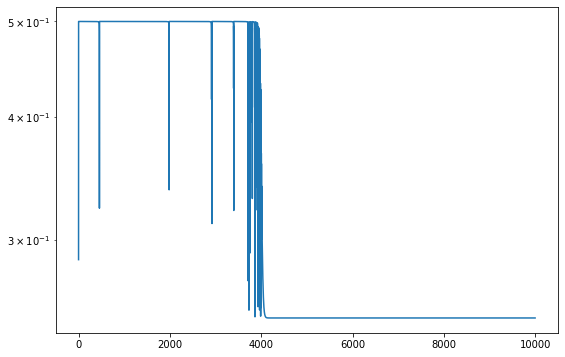

In [20]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [21]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', BCE_loss(a[nLayers],outputs)/batchSize)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[-0.05577262, -0.03103956],
       [-0.07368486, -0.04011118],
       [-0.05089614, -0.0255724 ],
       ...,
       [-0.00212371,  0.01262351],
       [ 0.03362609,  0.05051189],
       [-0.02864154,  0.00233306]], dtype=float32), array([[-2.49010734e-02,  4.30592261e-02, -2.84471419e-02, ...,
        -1.37070119e-02, -5.53595573e-02, -1.39450822e-02],
       [-1.07315155e-02, -5.10806143e-02,  5.09589016e-02, ...,
         4.97468337e-02, -4.45356704e-02,  4.29743491e-02],
       [ 1.00306012e-02, -1.67910513e-02, -4.16486617e-03, ...,
         4.97106602e-03, -5.23765702e-05,  2.13311389e-02],
       ...,
       [-4.27794829e-02, -7.86562916e-03,  4.56173345e-02, ...,
         4.54445332e-02,  1.17491744e-02, -4.47695144e-02],
       [ 3.14776748e-02, -3.89184542e-02, -2.31186058e-02, ...,
        -3.95420827e-02,  2.17327233e-02,  5.47779258e-03],
       [-2.86995005e-02,  2.33958010e-02,  3.00553814e-02, ...,
         1.62228532e-02, -5.25346547e-02, -2

New Average Error with optimized weights:
 0.6931407767489828
Input:  [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
Output:  [[0.49970785]
 [0.4999061 ]
 [0.50010085]
 [0.5002861 ]]
Expected Output:  [[0.]
 [1.]
 [1.]
 [0.]]


In [22]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
0.0051604956
0.006700722

Layer :  2
0.0057137497
0.01111472

Layer :  3
0.060572173
0.0052085686


# PyTorch

In [23]:
### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

## Generate the network programatically

## Method 1

In [24]:
Layers = []
# Input layer
Layers.append(torch.nn.Linear(nInputs, neurons_per_layer[0]))
Layers.append(torch.nn.Sigmoid())

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Layers.append(torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Layers.append(torch.nn.Sigmoid())
    # Output layer
    Layers.append(torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Layers.append(torch.nn.Sigmoid())

In [25]:
Network = torch.nn.Sequential(*Layers)

In [26]:
print(Network)

Sequential(
  (0): Linear(in_features=2, out_features=1000, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=1000, out_features=500, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=500, out_features=1, bias=True)
  (5): Sigmoid()
)


## Method 2 (Suitable for us to modify weights for each layer to be same as keras and my implementation)

In [27]:
Network = torch.nn.Sequential()
 
# Input layer -> 1st hidden layer
Network.add_module(str(0),torch.nn.Linear(nInputs, neurons_per_layer[0]))
# Activation function after first hidden layer
Network.add_module('act0',act_func_dict_PyTorch[activation_func_names[0]])

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Network.add_module(str(i),torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Network.add_module('act'+str(i),act_func_dict_PyTorch[activation_func_names[i]])
        
    # Output layer
    Network.add_module(str(nLayers-1),torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Network.add_module('act'+str(nLayers-1),act_func_dict_PyTorch[activation_func_names[nLayers-1]])

In [28]:
# torch.nn.init.constant_(Network.weight, 2.0)
Network.to(device=device)

Sequential(
  (0): Linear(in_features=2, out_features=1000, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=1000, out_features=500, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=500, out_features=1, bias=True)
  (act2): Sigmoid()
)

## initial weights and biases generated by Pytorch

In [29]:
print(Network[0].weight)
print(Network[0].bias)

Parameter containing:
tensor([[-0.0390,  0.1637],
        [ 0.0264, -0.5530],
        [-0.3134, -0.0266],
        ...,
        [-0.0008, -0.1820],
        [-0.5779, -0.0867],
        [ 0.0053,  0.6173]], requires_grad=True)
Parameter containing:
tensor([-0.0732,  0.6718, -0.4022,  0.0712,  0.5870,  0.5849,  0.5105, -0.3166,
        -0.3169, -0.0612,  0.1592, -0.5587, -0.3078, -0.5053, -0.2475, -0.6646,
        -0.2420,  0.0880,  0.3982, -0.4693,  0.0594, -0.0688,  0.5263,  0.5896,
        -0.2505, -0.0892,  0.4727, -0.4073,  0.3924,  0.4741,  0.3182, -0.6618,
         0.2092, -0.0600,  0.3236,  0.3677,  0.3958,  0.4354, -0.6298,  0.1271,
         0.3684, -0.4715,  0.3743, -0.1326, -0.5025, -0.2115,  0.4637,  0.6113,
        -0.1967,  0.4497,  0.0891, -0.1764, -0.0057, -0.6983, -0.3637, -0.0912,
        -0.5402,  0.1234,  0.3723, -0.1119, -0.2005, -0.0112, -0.6822, -0.0271,
         0.5765,  0.4063,  0.2938,  0.2863,  0.1834, -0.1474, -0.6710,  0.3582,
         0.2907, -0.2102,  0.6809,

## Change them to be the same as others

## **IMPORTANT NOTE**: The returned tensor and the original array share the same memory. So any changes to the tensor change the array as well.

Reference: https://pytorch.org/docs/stable/generated/torch.from_numpy.html



In [30]:
for i in range(nLayers):
    # Weights
#     Network._modules[str(i)].weight.data = torch.from_numpy(weightsOriginal[i]).to(dtype=torch.float32)
    Network._modules[str(i)].weight.data = torch.tensor(weightsOriginal[i]).to(dtype=torch.float32)
    # Biases
#     Network._modules[str(i)].bias.data = torch.from_numpy(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32
    Network._modules[str(i)].bias.data = torch.tensor(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32

In [31]:
for i in range(nLayers):
    # Weights
    print('Weights:\n')
    print(Network._modules[str(i)].weight.data)
    # Biases
    print('Biases:\n')
    print(Network._modules[str(i)].bias.data)

Weights:

tensor([[-0.0548, -0.0312],
        [-0.0751, -0.0412],
        [-0.0518, -0.0277],
        ...,
        [-0.0027,  0.0120],
        [ 0.0311,  0.0490],
        [-0.0311,  0.0008]])
Biases:

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [32]:
### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
# crit = torch.nn.BCELoss()
# opt = torch.optim.SGD(Network.parameters(), lr=0.2)

crit = torch.nn.MSELoss()
opt = torch.optim.SGD(Network.parameters(), lr=eeta)

Sequential(
  (0): Linear(in_features=2, out_features=1000, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=1000, out_features=500, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=500, out_features=1, bias=True)
  (act2): Sigmoid()
)
1005001 trainable parameters


In [33]:
inputsTorch = torch.from_numpy(inputs)
inputsTorch = inputsTorch.to(dtype=torch.float32) # Convert to float32
labels = torch.from_numpy(outputs)
labels = labels.to(dtype=torch.float32) # Convert to float32

In [34]:
print(inputsTorch)
print(labels)

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])
tensor([[0.],
        [1.],
        [1.],
        [0.]])


In [35]:
%%time
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, nEpochs)
errorPlot = []
### Train the model
for e in tqdm(epochs,leave=True,miniters=100):
    tr_loss = 0.
    samples = 0
    
    opt.zero_grad() # zero gradient values
    inputsTorch = inputsTorch.to(device=device) # move input and label tensors to the device with the model
    labels = labels.to(device=device)
    outputsTorch = Network(inputsTorch) # compute model outputs
    loss = crit(outputsTorch, labels) # compute batch loss
    loss.backward() # back-propagate the gradients
    opt.step() # update the model weights
    tr_loss += loss.clone().cpu().item()*len(inputsTorch) # add the batch loss to the running loss
    samples += len(inputsTorch) # update the number of processed samples
    tr_loss /= samples # compute training loss
    errorPlot.append(tr_loss)
#     print(e, tr_loss)

  0%|          | 0/9999 [00:00<?, ?it/s]

Wall time: 20.4 s


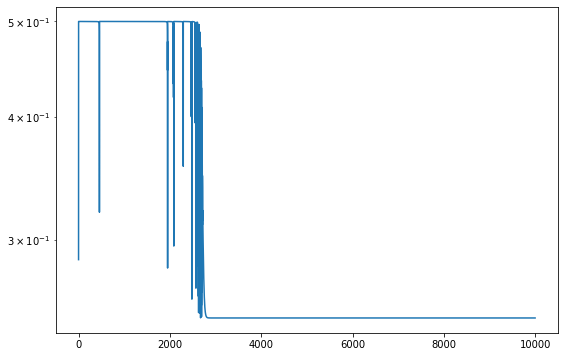

In [36]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [37]:
print('Difference b/w our weights & biases and PyTorch results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(torch.tensor(optWeights[i]).to(dtype=torch.float32)-Network._modules[str(i)].weight.data).max())
    print(abs(torch.tensor(optBiases[i]).to(dtype=torch.float32)-Network._modules[str(i)].bias.data).max())

Difference b/w our weights & biases and PyTorch results:

Layer :  1
tensor(0.0007)
tensor(0.0002)

Layer :  2
tensor(0.0002)
tensor(2.8644e-05)

Layer :  3
tensor(0.0027)
tensor(0.0028)


In [59]:
torch.get_num_threads()

8

In [60]:
# torch.set_num_threads(4)
torch.get_num_threads()

8

In [61]:
torch.get_num_threads()

8